<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/DT_photoz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Regression problem

In this notebook we will use decision tree and random forests algorihtms to learn a mapping between galaxy magnitudes and colors and the spectroscopic redshift.

We will construct some learning curves to determine the best choices of the algorihtms.

We will then use feature importance to understand which of the features give us the most predictive power, and then train a very simiple algorithm with reduced feature list.


# Load some libraries

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split

# Doanload the dataset

In [2]:
! wget --no-check-certificate https://drive.google.com/open?id=1Wdy5-wnVFaRK-Xx3j4osQsMDoA6O9VeB

--2019-06-06 06:25:59--  https://alien.usm.uni-muenchen.de/SDSS/SpecPhotodr14_hoyleb.csv.sampled.fits.bz2
Resolving alien.usm.uni-muenchen.de (alien.usm.uni-muenchen.de)... 129.187.203.185, 2001:4ca0:4101:0:81:bb:cb:b9
Connecting to alien.usm.uni-muenchen.de (alien.usm.uni-muenchen.de)|129.187.203.185|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 200 OK
Length: 243911221 (233M) [application/x-bzip2]
Saving to: ‘SpecPhotodr14_hoyleb.csv.sampled.fits.bz2’

SpecPhotodr14_hoyle 100%[===================>] 232.61M  7.12MB/s    in 34s     

2019-06-06 06:26:34 (6.79 MB/s) - ‘SpecPhotodr14_hoyleb.csv.sampled.fits.bz2’ saved [243911221/243911221]



# Clean the data

In [0]:
d = Table.read('SpecPhotodr14_hoyleb.csv.sampled.fits.bz2')
# will perform a bit of data cleaning.
d = d[d['SPEC_Z'] < 1.0]
d = d[d['SPEC_Z'] > 1e-3]

In [17]:
#you can look at the all the features available to you
# http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoObj+V
print (d.keys())

['OBJID', 'RA', 'DEC', 'PHOTPTYPE', 'PHOT_SG', 'FLAGS', 'SATURATED', 'BAD_COUNTS_ERROR', 'BINNED1', 'u', 'g', 'r', 'i', 'z', 'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'MODELMAGERR_U', 'MODELMAGERR_G', 'MODELMAGERR_R', 'MODELMAGERR_I', 'MODELMAGERR_Z', 'EXTINCTION_U', 'EXTINCTION_G', 'EXTINCTION_R', 'EXTINCTION_I', 'EXTINCTION_Z', 'DERED_U', 'DERED_G', 'DERED_R', 'DERED_I', 'DERED_Z', 'PETRORAD_U', 'PETRORAD_G', 'PETRORAD_R', 'PETRORAD_I', 'PETRORAD_Z', 'PETRORADERR_U', 'PETRORADERR_G', 'PETRORADERR_R', 'PETRORADERR_I', 'PETRORADERR_Z', 'DEVRAD_U', 'DEVRADERR_U', 'DEVRAD_G', 'DEVRADERR_G', 'DEVRAD_R', 'DEVRADERR_R', 'DEVRAD_I', 'DEVRADERR_I', 'DEVRAD_Z', 'DEVRADERR_Z', 'DEVAB_U', 'DEVAB_G', 'DEVAB_R', 'DEVAB_I', 'DEVAB_Z', 'CMODELMAG_U', 'CMODELMAGERR_U', 'CMODELMAG_G', 'CMODELMAGERR_G', 'CMODELMAG_R', 'CMODELMAGERR_R', 'CMODELMAG_I', 'CMODELMAGERR_I', 'CMODELMAG_Z', 'CMODELMAGERR_Z', 'PSFMAG_U', 'PSFMAGERR_U', 'PSFMAG_G', 'PSFMAGERR_G', 'PSFMAG_R', 'PSFMAGERR_R', 'PSFMAG_I', 'PSFMAG

In [0]:
# we will use just dereddend magnitudes 
mags = ['DERED_U', 'DERED_G', 'DERED_R','DERED_I','DERED_Z']
d=d[d[mags[0]]!='null']
d=d[d[mags[1]]!='null']
d=d[d[mags[2]]!='null']
d=d[d[mags[3]]!='null']
d=d[d[mags[4]]!='null']

def f(x):
    return np.float(x)
f2 = np.vectorize(f)

#and color combinations created from them.
cols= []
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        cols.append(mags[i]+'-' + mags[j])

# let's load these into an input array
inputs = np.zeros((len(d), len(mags+cols)), dtype=float)
for i, key in enumerate(mags):
    inputs[:, i] = np.array(d[key])

cnt = len(mags)
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        inputs[:, cnt] = np.array(f2(d[mags[i]])) - np.array(f2(d[mags[j]]))
        cnt += 1


# for photo-z work
# The target/label values are spectroscopic redshifts

In [0]:
targets = np.array(f2(d['SPEC_Z']))

# we will split the data into a trainind and testing sample.


In [0]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.4, random_state=42)


In [0]:
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
    
#see https://scikit-learn.org/stable/modules/tree.html

#help(DT)

#let's train [.fit()]  a tree on the training sample, and then make predictions on the test sample

0.01635119479102708 0.01627702772254711


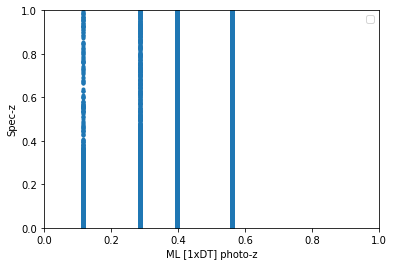

In [117]:
clf = DT(random_state=0, max_depth=2)
clf = clf.fit(x_train, y_train)

pred_train  = clf.predict(x_train)
pred_test = clf.predict(x_test)

mse_test = mean_squared_error(y_test, pred_test)
mse_train = mean_squared_error(y_train, pred_train)
plt.plot(pred_test,y_test, '.')#, label='test MSE={:0.2f}'.format(mse_test))
plt.legend()
plt.xlabel('ML [1xDT] photo-z')
plt.ylabel('Spec-z')
plt.xlim([0,1])
plt.ylim([0,1])

print mse_test, mse_train


# Show graph

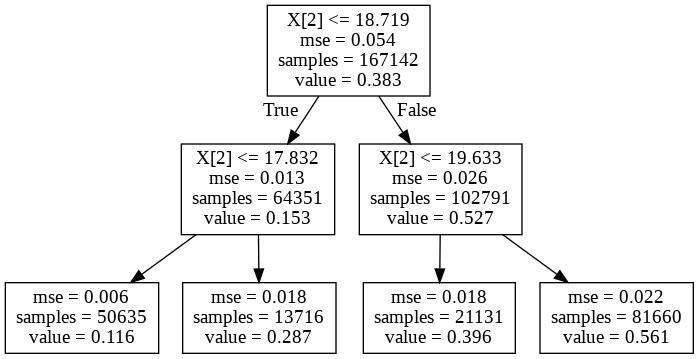

In [108]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data=export_graphviz(clf)

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

# Lets increase the number of trees -> forest

In [0]:
#for regression [photo-z]
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

clf = RandomForestRegressor(max_depth=8,n_estimators=50)

0.008167039454391425 0.0074583807883365156


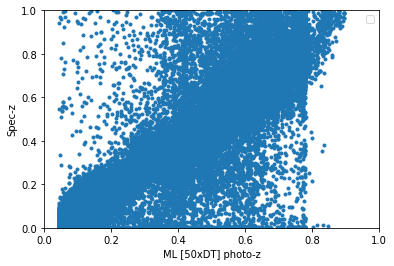

In [115]:
clf = clf.fit(x_train, y_train)

#replace None
pred_train  = clf.predict(x_train)
pred_test = clf.predict(x_test)

mse_test = mean_squared_error(y_test, pred_test)
mse_train = mean_squared_error(y_train, pred_train)
plt.plot(pred_test,y_test, '.')#, label='test MSE={:0.2f}'.format(mse_test))
plt.legend()
plt.xlabel('ML [50xDT] photo-z')
plt.ylabel('Spec-z')
plt.xlim([0,1])
plt.ylim([0,1])

print mse_test, mse_train